## IMPORTING NECESSARY LIBRARIES

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import time
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from torchsummary import summary

## SAMPLE TRAINING IMAGE AND ITS MASK

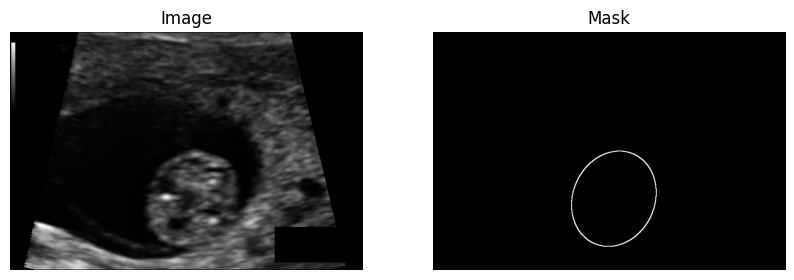

In [2]:
# Define paths
base_dir = "/kaggle/input/fetal-head-ultrasound/training_set/training_set"
image_name = "000_HC.png"
mask_name = "000_HC_Annotation.png"

# Full paths to the image and mask
image_path = os.path.join(base_dir, image_name)
mask_path = os.path.join(base_dir, mask_name)

# Load the image and mask using PIL
image = Image.open(image_path)
mask = Image.open(mask_path)

# Convert to numpy arrays for further processing (optional)
image_array = np.array(image)
mask_array = np.array(mask)

# Display the image and mask
plt.figure(figsize=(10, 5))

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Image")
plt.axis('off')

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.show()

# IMAGE PRE-PROCESSING

### 1. Fill all the masks 
### 2. Perform Augmentation on our data to increase training dataset 
### 3. Reshape all images and masks to 512x512
### 4. Perform Normalization on Images & Binarization on Masks


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Processing images and masks: 100%|██████████| 999/999 [01:11<00:00, 13.88it/s]


Processing complete! Images and masks are saved in: /kaggle/working/modified_training_data
Unique values in 000_HC_Annotation.png: [  0 255]
Unique values in 000_HC_Annotation_aug0.png: [  0 255]
Unique values in 000_HC_Annotation_aug1.png: [  0 255]
Unique values in 000_HC_Annotation_aug2.png: [  0 255]


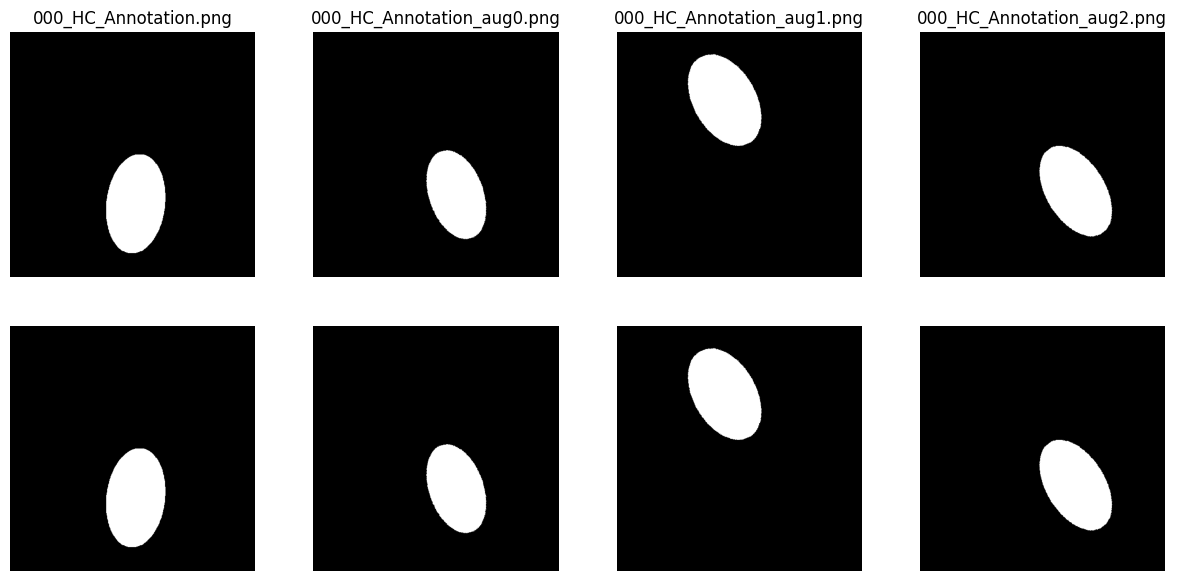

Number of files in working directory to indicate augmentation: 7992


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast,
    ShiftScaleRotate
)
from tqdm import tqdm

# Define paths
base_dir = "/kaggle/input/fetal-head-ultrasound/training_set/training_set"
output_dir = "/kaggle/working/modified_training_data"
os.makedirs(output_dir, exist_ok=True)

# Define augmentation pipeline
augmentation = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
])

# Function to fill enclosed areas in masks
def fill_mask(mask):
    mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
    h, w = mask.shape
    mask_floodfill = mask.copy()
    mask_floodfill_inv = np.zeros((h+2, w+2), np.uint8)
    
    cv2.floodFill(mask_floodfill, mask_floodfill_inv, (0, 0), 255)  
    mask_filled = cv2.bitwise_or(mask, cv2.bitwise_not(mask_floodfill))  
    return mask_filled

# Function to load image and mask
def load_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    if mask is None:
        raise ValueError(f"Failed to load mask: {mask_path}")

    mask = fill_mask(mask)  # Ensure enclosed regions are filled
    mask = (mask > 0).astype(np.uint8) * 255  # Binarize mask

    return image, mask

# Function to save augmented images and masks
def save_augmented(image, mask, image_name, mask_name):
    cv2.imwrite(os.path.join(output_dir, image_name), (image * 255).astype(np.uint8))
    cv2.imwrite(os.path.join(output_dir, mask_name), mask)

# Get list of images and masks
image_files = [f for f in os.listdir(base_dir) if f.endswith("HC.png")]
mask_files = [f.replace("HC.png", "HC_Annotation.png") for f in image_files]

# Augmentation
num_augmentations = 3  

for i in tqdm(range(len(image_files)), desc="Processing images and masks"):
    image_path = os.path.join(base_dir, image_files[i])
    mask_path = os.path.join(base_dir, mask_files[i])

    # Load, resize, and preprocess
    image, mask = load_image_and_mask(image_path, mask_path)
    resized_image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_LINEAR)
    resized_mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

    # Save original resized image and mask
    save_augmented(resized_image, resized_mask, image_files[i], mask_files[i])

    # Apply augmentations
    for j in range(num_augmentations):
        augmented = augmentation(image=resized_image, mask=resized_mask)
        aug_image, aug_mask = augmented["image"], augmented["mask"]

        # Ensure masks are binary
        aug_mask = (aug_mask > 0).astype(np.uint8) * 255

        # Save augmented versions
        save_augmented(aug_image, aug_mask, f"{image_files[i].split('.')[0]}_aug{j}.png", f"{mask_files[i].split('.')[0]}_aug{j}.png")

print("Processing complete! Images and masks are saved in:", output_dir)

# Plot sample masks to verify
sample_masks = sorted([f for f in os.listdir(output_dir) if "HC_Annotation" in f])[:4]

fig, axes = plt.subplots(2, 4, figsize=(15, 7))

for idx, mask_name in enumerate(sample_masks):
    mask_path = os.path.join(output_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Ensure the mask is correctly binarized (debugging step)
    print(f"Unique values in {mask_name}: {np.unique(mask)}")

    axes[0, idx].imshow(mask, cmap='gray', vmin=0, vmax=255)
    axes[0, idx].set_title(mask_name)
    axes[0, idx].axis('off')

    # Second row should show the binary mask in the correct range
    axes[1, idx].imshow(mask, cmap='gray', vmin=0, vmax=255)
    axes[1, idx].axis('off')

plt.show()
print(f"Number of files in working directory to indicate augmentation: {len(os.listdir(output_dir))}")

# U - Net Model

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 106s 701ms/step - dice_coefficient: 0.4759 - loss: 1.3629 - val_dice_coefficient: 0.2456 - val_loss: 1.6515 - learning_rate: 1.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 300ms/step - dice_coefficient: 0.7580 - loss: 0.7701 - val_dice_coefficient: 0.1306 - val_loss: 1.9433 - learning_rate: 1.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 300ms/step - dice_coefficient: 0.8109 - loss: 0.6418 - val_dice_coefficient: 0.1010 - val_loss: 2.0506 - learning_rate: 1.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 300ms/step - dice_coefficient: 0.8506 - loss: 0.5515 - val_dice_coefficient: 0.4012 - val_loss: 1.3241 - learning_rate: 1.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 300ms/step - dice_coefficient: 0.8731 - loss: 0.4929 - val_dice_coefficient: 0.7310 - val_loss: 0.7412 - learning_rate: 1.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 300ms/step - dice_coefficient: 0.8883 - loss: 0.4617 - val_dice_coefficient: 0.6669 - val_lo

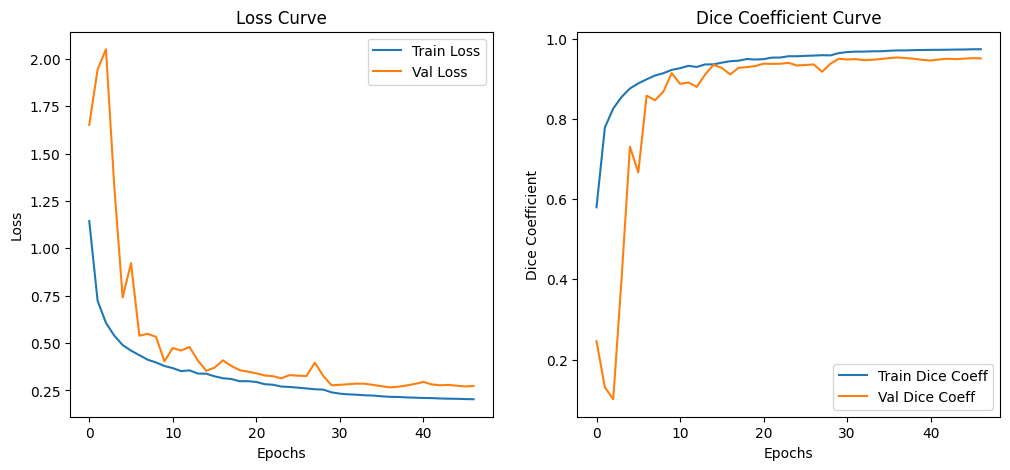

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 223ms/step - dice_coefficient: 0.9531 - loss: 0.2712
Test Dice Coefficient: 0.9512


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

# Define Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss (1 - Dice Coefficient)
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Combined Loss: Binary Crossentropy + Dice Loss
def combined_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Load Images & Masks
def load_data(image_dir, mask_dir, img_size=(512, 512)):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png") and "HC.png" in f])
    mask_files = [f.replace("HC.png", "HC_Annotation.png") for f in image_files]

    images, masks = [], []
    for img_file, mask_file in zip(image_files, mask_files):
        img = cv2.imread(os.path.join(image_dir, img_file), cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.uint8)  # Ensure binary mask

        img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

        images.append(img)
        masks.append(mask)

    images = np.expand_dims(np.array(images), axis=-1)  # Add channel dim
    masks = np.expand_dims(np.array(masks).astype(np.float32), axis=-1)  # Convert to float32

    return images, masks

# U-Net Model
def build_unet(input_shape=(512, 512, 1)):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    def conv_block(x, filters):
        x = layers.Conv2D(filters, (3, 3), padding="same", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3, 3), padding="same", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(c)
        p = layers.Dropout(0.2)(p)
        return c, p

    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    # Bottleneck
    bottleneck = conv_block(p4, 512)

    # Decoder
    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
        x = layers.concatenate([x, skip])
        x = layers.Dropout(0.2)(x)
        x = conv_block(x, filters)
        return x

    d4 = decoder_block(bottleneck, c4, 256)
    d3 = decoder_block(d4, c3, 128)
    d2 = decoder_block(d3, c2, 64)
    d1 = decoder_block(d2, c1, 32)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(d1)

    model = keras.Model(inputs, outputs)
    return model

# Load Dataset
image_dir = "/kaggle/working/modified_training_data"
mask_dir = "/kaggle/working/modified_training_data"
images, masks = load_data(image_dir, mask_dir)

# Train-Validation-Test Split (70-20-10)
train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=0.1, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Build U-Net Model
model = build_unet(input_shape=(512, 512, 1))

# Compile Model with Adam, Dice Loss & Dice Coefficient
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=[dice_coefficient])

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)

# Train Model
history = model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    # Dice Coefficient
    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coefficient'], label="Train Dice Coeff")
    plt.plot(history.history['val_dice_coefficient'], label="Val Dice Coeff")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficient")
    plt.legend()
    plt.title("Dice Coefficient Curve")

    plt.show()

# Plot Training Performance
plot_history(history)

# Evaluate on Test Set
test_loss, test_dice = model.evaluate(test_x, test_y)
print(f"Test Dice Coefficient: {test_dice:.4f}")

# Save Model
model.save("/kaggle/working/fetal_head_segmentation_unet.h5")


# U-net Summary


In [9]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 512, 512, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 512, 512, 32)   │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 512, 512, 32)   │            128 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_18 (ReLU)           │ (None, 512, 512, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 512, 512, 32)   │          9,248 │ re_lu_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 512, 512, 32)   │            128 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 512, 512, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 256, 256, 32)   │              0 │ re_lu_19[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 256, 256, 32)   │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 256, 256, 64)   │         18,496 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 256, 256, 64)   │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ re_lu_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 256, 256, 64)   │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_21 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 128, 128, 64)   │              0 │ re_lu_21[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 23,302,117 (88.89 MB)

 Trainable params: 7,765,409 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

 Optimizer params: 15,530,820 (59.25 MB)

# Res-U net Model

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - dice_coefficient: 0.4883 - loss: 1.3353 - val_dice_coefficient: 0.0664 - val_loss: 2.2332 - learning_rate: 1.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 835ms/step - dice_coefficient: 0.7615 - loss: 0.7730 - val_dice_coefficient: 0.0016 - val_loss: 3.4641 - learning_rate: 1.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 828ms/step - dice_coefficient: 0.8312 - loss: 0.6135 - val_dice_coefficient: 0.0015 - val_loss: 3.4765 - learning_rate: 1.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 826ms/step - dice_coefficient: 0.8649 - loss: 0.5342 - val_dice_coefficient: 0.1087 - val_loss: 2.4602 - learning_rate: 1.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 833ms/step - dice_coefficient: 0.8881 - loss: 0.4769 - val_dice_coefficient: 0.4006 - val_loss: 1.7980 - learning_rate: 1.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 830ms/step - dice_coefficient: 0.9009 - loss: 0.4446 - val_dice_coefficient: 0.7133 - val_loss:

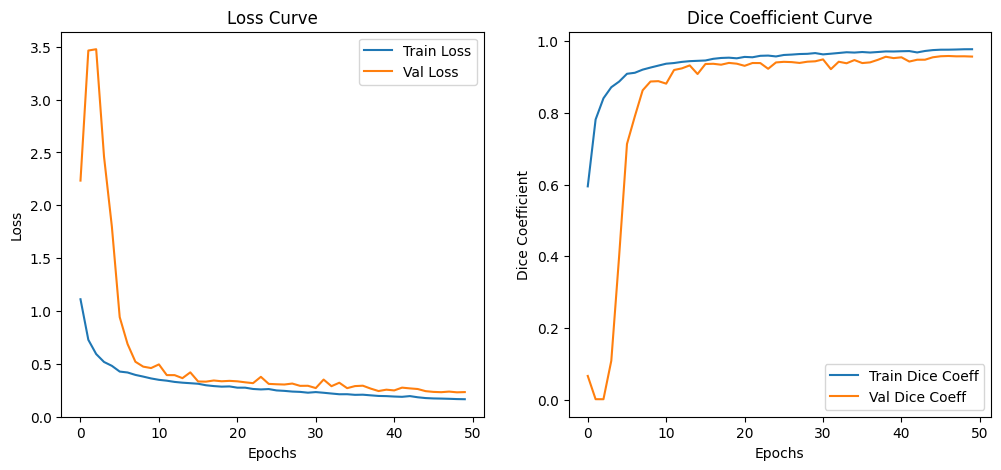

4/4 ━━━━━━━━━━━━━━━━━━━━ 65s 625ms/step - dice_coefficient: 0.9553 - loss: 0.2427
Test Dice Coefficient: 0.9545


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

# Define Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss (1 - Dice Coefficient)
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Combined Loss: Binary Crossentropy + Dice Loss
def combined_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Load Images & Masks
def load_data(image_dir, mask_dir, img_size=(512, 512)):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png") and "HC.png" in f])
    mask_files = [f.replace("HC.png", "HC_Annotation.png") for f in image_files]

    images, masks = [], []
    for img_file, mask_file in zip(image_files, mask_files):
        img = cv2.imread(os.path.join(image_dir, img_file), cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.uint8)  # Ensure binary mask

        img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

        images.append(img)
        masks.append(mask)

    images = np.expand_dims(np.array(images), axis=-1)  # Add channel dim
    masks = np.expand_dims(np.array(masks).astype(np.float32), axis=-1)  # Convert to float32

    return images, masks

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(filters, (1, 1), padding="same")(shortcut)  # Ensure dimensions match
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

# ResU-Net Model
def build_resunet(input_shape=(512, 512, 1)):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    def encoder_block(x, filters):
        c = residual_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(c)
        p = layers.Dropout(0.2)(p)
        return c, p

    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    # Bottleneck
    bottleneck = residual_block(p4, 512)

    # Decoder
    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
        x = layers.concatenate([x, skip])
        x = layers.Dropout(0.2)(x)
        x = residual_block(x, filters)
        return x

    d4 = decoder_block(bottleneck, c4, 256)
    d3 = decoder_block(d4, c3, 128)
    d2 = decoder_block(d3, c2, 64)
    d1 = decoder_block(d2, c1, 32)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(d1)

    model = keras.Model(inputs, outputs)
    return model

# Load Dataset
image_dir = "/kaggle/working/modified_training_data"
mask_dir = "/kaggle/working/modified_training_data"
images, masks = load_data(image_dir, mask_dir)

# Train-Validation-Test Split (70-20-10)
train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=0.1, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Build ResU-Net Model
model = build_resunet(input_shape=(512, 512, 1))

# Compile Model with Adam, Dice Loss & Dice Coefficient
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=[dice_coefficient])



# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)

# Train Model
history = model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    # Dice Coefficient
    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coefficient'], label="Train Dice Coeff")
    plt.plot(history.history['val_dice_coefficient'], label="Val Dice Coeff")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficient")
    plt.legend()
    plt.title("Dice Coefficient Curve")

    plt.show()

# Plot Training Performance
plot_history(history)

# Evaluate on Test Set
test_loss, test_dice = model.evaluate(test_x, test_y)
print(f"Test Dice Coefficient: {test_dice:.4f}")

# Save Model
model.save("/kaggle/working/fetal_head_segmentation_resunet.h5")


# Res-U net Summary

In [6]:
# Print Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 512, 512, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 512, 512, 32)   │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512, 512, 32)   │              0 │ batch_normalization_1… │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 512, 512, 32)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 32)   │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 32)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 256, 256, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 24,351,109 (92.89 MB)

 Trainable params: 8,115,073 (30.96 MB)

 Non-trainable params: 5,888 (23.00 KB)

 Optimizer params: 16,230,148 (61.91 MB)